<a href="https://colab.research.google.com/github/rgclapp007/labX/blob/main/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab X



Lets begin by opening up colab. Click on colab banner on the github page. This should open up your own copy of this lab.

Welcome to lab X. Today you will be doing Y.

Here is a bunch of stuff describing what we are doing in the lab.



First we need to setup your lab. Run the following cell to install the software we are using for this exercise.

In [8]:
!pip install platypus-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Run the following cell to get the data we are using for this lab. If your colab instance times out you will need to rerun this cell.

In [9]:
!git clone https://premonition.stanford.edu/bob/labtest-data.git Data

fatal: destination path 'Data' already exists and is not an empty directory.


Next lets load some of the packags we are going to use for this lab.

In [10]:

# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import functools
from platypus import NSGAII, Problem, Real


Now some code

In [11]:
# Define Program Functions

# Hedge Control Simulation Function 
# same function, but now returns 2 objectives
def simulate(x, streamflow):
    S = np.zeros(T)
    R = np.zeros(T)
    cost = np.zeros(T)
    h0 = x[0]
    hf = x[1]
    Q = streamflow
    
    S[0] = K # start simulation full
    reliability = 0
    
    for t in range(1,T):
        
        # new storage: mass balance, max value is K
        S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
        
        # determine R from hedging policy
        W = S[t] + Q[t]
        if W > hf:
            R[t] = D
            reliability += 1.0/T
        elif W < h0:
            R[t] = W
        else:
            R[t] = (D-h0)/(hf-h0)*(W-h0)+h0
        
        shortage = D-R[t]
        cost[t] = a*shortage**b
        
    return [cost.mean(), reliability]

# Define simulate_2 as a duplicate version of simulate function that returns storage
def simulate_2(x, streamflow):
    S = np.zeros(T)
    R = np.zeros(T)
    cost = np.zeros(T)
    h0 = x[0]
    hf = x[1]
    Q = streamflow
    
    S[0] = K # start simulation full
    reliability = 0
    
    for t in range(1,T):
        
        # new storage: mass balance, max value is K
        S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
        
        # determine R from hedging policy
        W = S[t] + Q[t]
        if W > hf:
            R[t] = D
            reliability += 1.0/T
        elif W < h0:
            R[t] = W
        else:
            R[t] = (D-h0)/(hf-h0)*(W-h0)+h0
        
        shortage = D-R[t]
        cost[t] = a*shortage**b
        
    return [cost.mean(), reliability, S]

# Define Simulation-Based Optimization Function
def multiobj_sim(flows):
    # Problem(number of decisions, number of objectives)
    problem = Problem(2, 2)
    problem.types[0] = Real(0,D)
    problem.types[1] = Real(D,K+D)
    problem.directions[1] = Problem.MAXIMIZE
    problem.function = functools.partial(simulate, streamflow=flows)
    
    algorithm = NSGAII(problem)
    
    # optimize the problem using 10000 function evaluations
    algorithm.run(10000)
    
    # just plotting below here ~~~~~~~~~~~~~
    # convert data to numpy first..
    obj = np.array([s.objectives for s in algorithm.result])
    x = np.array([s.variables for s in algorithm.result])
    
    return [obj, x]

# Exceedance Plot from Assignment 1
def exceed (flows):
    exceeds = (np.arange(1.0,len(flows)+1.0)/(len(flows)+1.0))*100.0
    return (exceeds)

# Plot Formatting Function
def plot_format (fig,xlab,ylab,ticks_on,majcol,mincol):
    fig.xlabel(xlab)
    fig.ylabel(ylab)
    fig.grid(b=True, which='major', color= majcol, linestyle='-')
    fig.grid(b=True, which='minor', color= mincol, linestyle='-')
    if ticks_on == True:
        fig.minorticks_on()
        fig.tick_params(axis="y", which ='both', direction="in", length = 0)
        fig.tick_params(axis="x", which ='both', direction="in", length = 0)
    return(fig)

# Finds index of value in numpy array that is closest to value of interest
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx)


In [12]:
# Set some parameters
K = 975 # capacity, TAF
D = 150 # target yield, TAF
a = 0.35
b = 2.3 # cost function parameters

# data setup
historical_flow = np.loadtxt('Data/FOL-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1])
T = len(historical_flow)

# Define array of Months Since Oct 2000
mon = np.arange(0,T)

# Part A

# Define Dry Flow Conditions
dry_flow = 0.8*historical_flow

# Define Wet Flow Conditions
wet_flow = 1.2*historical_flow

# Define Variable Flow Conditions
# Determine historical flow mean and standard deviation
u = np.mean(historical_flow)*np.ones(len(historical_flow))
sig = ((np.var(historical_flow))**(.5))*np.ones(len(historical_flow))

# Calculate daily standardized anomalies
anol = (historical_flow-u)/sig
anol_v = 1.2*anol
variable_flow = anol_v*sig + u

# Truncate any negative values to 0
variable_flow[variable_flow<0] = 0



Historical Stream Flow Conditions
Reliability = 0.765
Shortage Cost = $565.61

Dry Stream Flow Conditions
Reliability = 0.508
Shortage Cost = $1879.00

Wet Stream Flow Conditions
Reliability = 0.860
Shortage Cost = $230.94

Variable Stream Flow Conditions
Reliability = 0.704
Shortage Cost = $1594.84


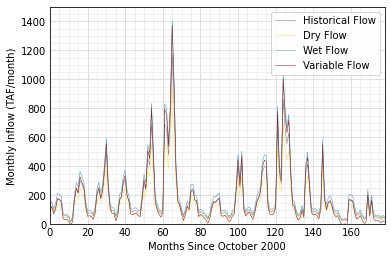

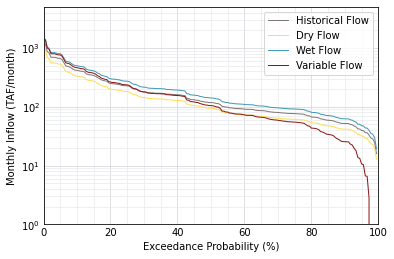

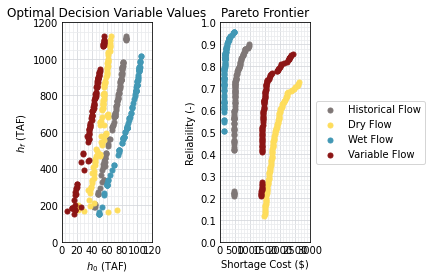

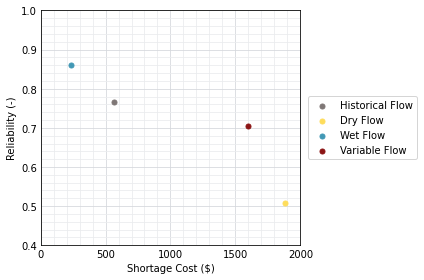

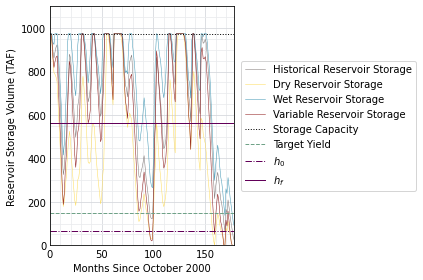

In [13]:
# Plot All Four Flow Types
plt.figure() # Define a new figure
plt.plot(mon, historical_flow, color='#7F7776', label='Historical Flow', linewidth=0.5)
plt.plot(mon, dry_flow, color='#FEDD5C', label='Dry Flow', linewidth=0.5)
plt.plot(mon, wet_flow, color='#4298B5', label='Wet Flow', linewidth=0.5)
plt.plot(mon, variable_flow, color='#8C1515', label='Variable Flow', linewidth=0.5)
plt.legend(loc="upper right")
plt.xlim([0,T-1])
plt.ylim([0,1500])
plt.yticks(np.arange(0,1500,200))
plot_format(plt,'Months Since October 2000','Monthly Inflow (TAF/month)',True,
    '#D5D8DC','#EAECEE')

# Plot Exceedance Plot for Alternative View
plt.figure() # Define a new figure
plt.plot(exceed(historical_flow), np.sort(historical_flow)[::-1], color='#7F7776', label='Historical Flow', linewidth=1)
plt.plot(exceed(dry_flow), np.sort(dry_flow)[::-1], color='#FEDD5C', label='Dry Flow', linewidth=1)
plt.plot(exceed(wet_flow), np.sort(wet_flow)[::-1], color='#4298B5', label='Wet Flow', linewidth=1)
plt.plot(exceed(variable_flow), np.sort(variable_flow)[::-1], color='#8C1515', label='Variable Flow', linewidth=1)
plt.legend(loc="upper right")
plt.xlim([0,100])
plt.xticks(np.arange(0,110,20))
plt.yscale('log')
plt.ylim([1,5*10**3])
plot_format(plt,'Exceedance Probability (%)','Monthly Inflow (TAF/month)',True,
    '#D5D8DC','#EAECEE')

# Part B

# Run the multi-objective simulation algorithm for each flow condition
[obj_his, x_his] = multiobj_sim(historical_flow)
[obj_dry, x_dry] = multiobj_sim(dry_flow)
[obj_wet, x_wet] = multiobj_sim(wet_flow)
[obj_var, x_var] = multiobj_sim(variable_flow)

plt.figure() # Define a new figure
plt.subplot(1,2,1)
# plt.contour(X,Y,costs.T, 50, cmap=plt.get_cmap('cool'))
# plt.contour(X,Y,rels.T, 50, cmap=plt.get_cmap('Reds'))
plt.scatter(x_his[:,0],x_his[:,1], s=25, color='#7F7776', label='Historical Flow', zorder=3)
plt.scatter(x_dry[:,0],x_dry[:,1], s=25, color='#FEDD5C', label='Dry Flow', zorder=3)
plt.scatter(x_wet[:,0],x_wet[:,1], s=25, color='#4298B5', label='Wet Flow', zorder=3)
plt.scatter(x_var[:,0],x_var[:,1], s=25, color='#8C1515', label='Variable Flow', zorder=3)
plt.xlim([0,120])
plt.xticks(np.arange(0,130,20))
plt.ylim([0,1200])
plt.yticks(np.arange(0,1300,200))
plt.title('Optimal Decision Variable Values')
plot_format(plt,r'$h_0$ (TAF)',r'$h_f$ (TAF)',True,'#D5D8DC','#EAECEE')

plt.subplot(1,2,2)
plt.scatter(obj_his[:,0],obj_his[:,1], s=25, color='#7F7776', label='Historical Flow', zorder=3)
plt.scatter(obj_dry[:,0],obj_dry[:,1], s=25, color='#FEDD5C', label='Dry Flow', zorder=3)
plt.scatter(obj_wet[:,0],obj_wet[:,1], s=25, color='#4298B5', label='Wet Flow', zorder=3)
plt.scatter(obj_var[:,0],obj_var[:,1], s=25, color='#8C1515', label='Variable Flow', zorder=3)
plt.xlim([0,3000])
plt.xticks(np.arange(0,3100,500))
plt.ylim([0,1])
plt.yticks(np.arange(0,1.1,0.1))
plt.title('Pareto Frontier')
plot_format(plt,'Shortage Cost ($)','Reliability (-)',True,'#D5D8DC','#EAECEE')
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
plt.tight_layout()

# Part E

# Simulate the values: ho = 63.6 and hf = 564.4 for all four streamflow scenarios

# Define decision variable values of interest 
ho_crit = 63.6
hf_crit = 564.4

# get objective values given ho and hf for all streamflow scenarios
[cost_his, rel_his, S_his] = simulate_2([ho_crit, hf_crit], historical_flow)
[cost_dry, rel_dry, S_dry] = simulate_2([ho_crit, hf_crit], dry_flow)
[cost_wet, rel_wet, S_wet] = simulate_2([ho_crit, hf_crit], wet_flow)
[cost_var, rel_var, S_var] = simulate_2([ho_crit, hf_crit], variable_flow)

# Print all results
scen = ['Historical', 'Dry', 'Wet', 'Variable']
rels = [rel_his, rel_dry, rel_wet, rel_var]
costs = [cost_his, cost_dry, cost_wet, cost_var]
for i in range(0,len(scen)):
    print('\n' + scen[i] + ' Stream Flow Conditions')
    print('Reliability = %.3f' %(rels[i]))
    print('Shortage Cost = $%.2f' %(costs[i]))

# Plot the objective values on a a scatter plot
plt.figure() # Define a new figure
plt.scatter(cost_his, rel_his, c = '#7F7776', s = 25, label='Historical Flow', zorder = 3)
plt.scatter(cost_dry, rel_dry, c = '#FEDD5C', s = 25, label='Dry Flow', zorder = 3)
plt.scatter(cost_wet, rel_wet, c = '#4298B5', s = 25, label='Wet Flow', zorder = 3)
plt.scatter(cost_var, rel_var, c = '#8C1515', s = 25, label='Variable Flow', zorder = 3)
plt.xlim([0,2000])
plt.xticks(np.arange(0,2100,500))
plt.ylim([0.4,1])
plt.yticks(np.arange(0.4,1.1,0.1))
plt.grid(zorder=0)
plot_format(plt,'Shortage Cost ($)','Reliability (-)',True,'#D5D8DC','#EAECEE')
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
plt.tight_layout()

# Plot the reservoir storage volume for each streamflow scenario and the reservoir capacity, target yield, h0, and  hf
plt.figure() # Define a new figure
plt.plot(mon, S_his, color='#7F7776', label='Historical Reservoir Storage', linewidth=0.5)
plt.plot(mon, S_dry, color='#FEDD5C', label='Dry Reservoir Storage', linewidth=0.5)
plt.plot(mon, S_wet, color='#4298B5', label='Wet Reservoir Storage', linewidth=0.5)
plt.plot(mon, S_var, color='#8C1515', label='Variable Reservoir Storage', linewidth=0.5)
plt.plot(mon, K*np.ones(T), color='black', label='Storage Capacity', linewidth=1, linestyle='dotted')
plt.plot(mon, D*np.ones(T), color='#6FA287', label='Target Yield', linewidth=1, linestyle='dashed')
plt.plot(mon, ho_crit*np.ones(T), color='#620059', label= r'$h_0$', linewidth=1, linestyle='dashdot')
plt.plot(mon, hf_crit*np.ones(T), color='#620059', label= r'$h_f$', linewidth=1)
plt.xlim([0,T-1])
plt.ylim([0,1100])
plt.yticks(np.arange(0,1100,200))
plt.grid(zorder=0)
plot_format(plt,'Months Since October 2000','Reservoir Storage Volume (TAF)',True,
    '#D5D8DC','#EAECEE')
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
plt.tight_layout()

# Show all Plots
plt.show()

Once you have finished the lab it is time to turn it in. On the top right portion of your browser you should see a "Share" button.  Click on it. You should see a copyLink on the bottom right.  Click on it. Paste that link into an email message (or canvas) or ... to your TA.